In [13]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from owslib.csw import CatalogueServiceWeb
from owslib.fes import PropertyIsEqualTo, PropertyIsLike, BBox
import pandas as pd
from ipyaggrid import Grid

csw = CatalogueServiceWeb('http://explorer-portal.australiaeast.cloudapp.azure.com/geonetwork/srv/eng/csw')

permit_query = PropertyIsEqualTo('csw:AnyText', '%Permits%')
csw.getrecords2(constraints=[permit_query], maxrecords=200)

data = {}
attribs = ['identifier', 'title', 'abstract', 'type', 'subjects' ]
for key in csw.records:
    record = csw.records[key]
    for attrib in attribs:
        if attrib not in data.keys():
            data[attrib] = []
        data[attrib].append(getattr(record, attrib))

df_record = pd.DataFrame(data)

record_column_defs = [{'field': c, 'width': 300, 'editable': True} for c in df_record.columns]

record_grid_options = {
    'columnDefs' : record_column_defs,
    'enableFilter':'true',
    'enableSorting':'true'
}

g_record = Grid(
    grid_data=df_record,
    grid_options=record_grid_options,
    theme='ag-theme-balham',
    columns_fit='',
    quick_filter=True,
    export_csv=True,
    export_excel=True
)

g_record

Grid(compress_data=True, export_mode='disabled', height='350px', menu={'buttons': [{'name': 'Export to CSV', '…

In [4]:
from owslib.csw import CatalogueServiceWeb

csw.getrecordbyid(id=['aecdf0b2b48a07a8f95888d245781b9dc2a3faec', 'b194c58124d86f7cab8a1890e8e51971ec6443d9'])

record = csw.records['aecdf0b2b48a07a8f95888d245781b9dc2a3faec']
petro_permit_layer = record.uris[0]

petro_permit_layer

{'protocol': 'OGC:WFS-1.1.0-http-get-feature',
 'name': 'Permits_Petroleum:Petroleum_Active_Permits',
 'description': 'Petroleum_Active_Permits',
 'url': 'https://data.nzpam.govt.nz/hosting/services/Permits/Petroleum/MapServer/WFSServer?'}

In [5]:
record = csw.records['b194c58124d86f7cab8a1890e8e51971ec6443d9']
mineral_permit_layer = record.uris[0]

mineral_permit_layer

{'protocol': 'OGC:WFS-1.1.0-http-get-feature',
 'name': 'Permits_Minerals:Mineral_Active_Permits',
 'description': 'Mineral_Active_Permits',
 'url': 'https://data.nzpam.govt.nz/hosting/services/Permits/Minerals/MapServer/WFSServer?'}

In [6]:
import geopandas as gpd
from requests import Request
from owslib.wfs import WebFeatureService

params = dict(
    service='WFS', 
    version="2.0.0", 
    request='GetFeature', 
    typeName=petro_permit_layer['name'], 
    outputFormat='geojson', 
    srsname='urn:ogc:def:crs:EPSG::4326',
    bbox='173.56,-39.24,175.47,-36.44'
)
q = Request('GET', petro_permit_layer['url'], params=params).prepare().url

petroleum_df = gpd.read_file(q)

petroleum_df.head()

,OBJECTID,Permit_Number,PERMIT_NONEXCLUSIVE_YN,PERMIT_DURATION_YEARS,PERMIT_DURATION_MONTHS,PERMIT_AREA,PERMIT_AREA_UNITS,PERMIT_OFFSHORE_ONSHORE,Status,PERMIT_STATUS_DATE,...,Owner_s_,Share_Percentage_s_,Operator,Mineral_s_,B1_PER_ID1,B1_PER_ID2,B1_PER_ID3,SHAPE.STArea__,SHAPE.STLength__,geometry
0,3306,50509,N,40,0,30.186,SQKM,Offshore,Active,25/11/2009,...,"Greymouth Petroleum Limited, Greymouth Petrole...","48, 50, 2",Greymouth Petroleum Limited,Petroleum,07ATX,00000,00113,3.019298e+07,25104.309930,POLYGON ((174.0835327292042 -39.02694444508606...
1,1599,51378,N,15,0,68.120,SQKM,Onshore,Active - Change Pending,2/12/2009,...,"Greymouth Gas Kaimiro Limited, Greymouth Gas P...","24.08, 20, 20, 20, 15.92",Greymouth Petroleum Mining Group Limited,"Condensate, Gas, LPG, Oil, Petroleum",08ATX,00000,00144,6.814331e+07,35244.802130,"POLYGON ((174.21214389113 -38.98902043211932, ..."
2,3308,53803,N,10,0,2.890,SQKM,Onshore,Active,22/02/2012,...,TAMARIND NZ ONSHORE LIMITED,100,TAMARIND NZ ONSHORE LIMITED,"Condensate, Gas, LPG, Oil, Petroleum",11ATX,00000,00124,2.895840e+06,6830.592604,POLYGON ((174.2183333342569 -39.20657638420603...
3,15333,57065,N,10,0,52.176,SQKM,Onshore,Active,1/04/2015,...,TAMARIND NZ ONSHORE LIMITED,100,TAMARIND NZ ONSHORE LIMITED,"Condensate, Gas, LPG, Oil, Petroleum",14ATX,00000,00140,5.219329e+07,44987.242742,POLYGON ((174.2208333318534 -39.14583333181125...
4,1685,57075,N,12,0,1365.124,SQKM,Offshore,Active,1/04/2015,...,"OMV New Zealand Limited, SAPURAOMV UPSTREAM (N...","70, 30",OMV New Zealand Limited,"Condensate, Gas, LPG, Oil, Petroleum",14ATX,00000,00150,1.366137e+09,160214.068495,POLYGON ((173.8333333331142 -38.83333333225493...


In [7]:
from ipywidgets import Text, HTML, Layout
import textwrap

from ipyleaflet import Map, GeoData, basemaps, LayersControl, WidgetControl

def click_handler (feature=None, **kwargs):
    if feature is not None:        
        html1.value = ''
        items = feature['properties']
        for item in items:
            html1.value += '<h6>{}: <b>{}</b></h6>'.format(item, textwrap.shorten(str(items[item]), width=40))
        
geo_data = GeoData(
    geo_dataframe=petroleum_df,
    style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    name='Petroleum Active Permits'
)
geo_data.on_click(click_handler)

m = Map(center=(-41.2865, 174.7762), zoom=6, layout=dict(height='800px'))
m.add_layer(geo_data)

html1 = HTML('')
html1.layout.margin = '0px 10px 10px 10px'
control1 = WidgetControl(widget=html1, position='bottomright')
m.add_control(control1)

m.add_control(LayersControl())

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [19]:
import geopandas as gpd
from requests import Request
from owslib.wfs import WebFeatureService

params = dict(
    service='WFS', 
    version="2.0.0", 
    request='GetFeature', 
    typeName='data.linz.govt.nz:layer-53564', 
    outputFormat='json',
    srsname='urn:ogc:def:crs:EPSG::4326',
    bbox='173.7165,-39.737,175.4963,-38.8528,EPSG:4326'
)
q = Request('GET', 'https://data.linz.govt.nz/services;key=e1cd2f7203d74a9ea5d179f269de890b/wfs', params=params).prepare().url

taranaki_rural_df = gpd.read_file(q)

taranaki_rural_df.head()

,id,napalis_id,start_date,name,recorded_area,overlays,type,legislation,section,reserve_purpose,ctrl_mg_vst,geometry
0,layer-53564.2991035,2991035,None,Mangapouri Cemetery - Local Purpose (Cemetery)...,20.4325,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,Cemetery,New Plymouth District Council,(POLYGON ((174.1296076505625 -39.1350512713130...
1,layer-53564.3004179,3004179,None,Pukekura Park Local Purpose (Community Purpose...,1.1935,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,Community Use,New Plymouth District Council,(POLYGON ((174.0882341009924 -39.0758864051503...
2,layer-53564.2802387,2802387,1978-01-01T00:00:00,New Plymouth Air Training Local Purpose Reserve,0.1238,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,Air Training,Air Cadet League of New Zealand (Inc),(POLYGON ((174.0866527330251 -39.0819205546201...
3,layer-53564.2802388,2802388,1979-01-01T12:00:00,Stratford Air Training Local Purpose Reserve,0.1312,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,Air Training,Air Cadet League of New Zealand Inc.,(POLYGON ((174.2884852667789 -39.3405695722368...
4,layer-53564.2802540,2802540,1894-01-01T00:00:00,Warea Cemetery Local Purpose Reserve,2.0234,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,Cemetery,South Taranaki District Council,(POLYGON ((173.8088137000605 -39.2337633216579...


In [20]:
geo_data = GeoData(
    geo_dataframe=taranaki_rural_df,
    style={'color': 'blue', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    name='Waihapa Petroleum Fields'
)

m = Map(center=(-41.2865, 174.7762), zoom=6, layout=dict(height='800px'))
m.add_layer(geo_data)

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [21]:
res_intersection = gpd.overlay(petroleum_df, taranaki_rural_df, how='intersection')

res_intersection.head()

,OBJECTID,Permit_Number,PERMIT_NONEXCLUSIVE_YN,PERMIT_DURATION_YEARS,PERMIT_DURATION_MONTHS,PERMIT_AREA,PERMIT_AREA_UNITS,PERMIT_OFFSHORE_ONSHORE,Status,PERMIT_STATUS_DATE,...,start_date,name,recorded_area,overlays,type,legislation,section,reserve_purpose,ctrl_mg_vst,geometry
0,3306,50509,N,40,0,30.186,SQKM,Offshore,Active,25/11/2009,...,None,Marfell Park Recreation Reserve (located in Ne...,0.0410,No,Reserve,Reserves Act 1977,s.17 - Recreation Reserve,NULL,New Plymouth District Council,POLYGON ((174.0479728666072 -39.07663332156638...
1,3306,50509,N,40,0,30.186,SQKM,Offshore,Active,25/11/2009,...,2008-01-01T00:00:00,Tapuae Marine Reserve,1404.3000,No,Marine Area,Marine Reserves Act 1971,s.3 - Marine Reserve,NULL,NULL,(POLYGON ((174.0107531828783 -39.0793626174161...
2,3306,50509,N,40,0,30.186,SQKM,Offshore,Active,25/11/2009,...,None,Sanders Park Recreation Reserve,0.4974,No,Reserve,Reserves Act 1977,s.17 - Recreation Reserve,NULL,New Plymouth District Council,"POLYGON ((174.059859382759 -39.06711480482609,..."
3,3306,50509,N,40,0,30.186,SQKM,Offshore,Active,25/11/2009,...,1987-01-01T00:00:00,Bayly Road Conservation Area,0.0155,No,Conservation Area,Conservation Act 1987,s.25 - Stewardship Area,NULL,NULL,POLYGON ((174.0416711498357 -39.06158192121801...
4,3306,50509,N,40,0,30.186,SQKM,Offshore,Active,25/11/2009,...,1961-01-01T12:00:00,Sugar Loaf Islands Wildlife Refuge,2.7316,Yes,Wildlife Area,Wildlife Act 1953,s.14 - Wildlife Refuge,NULL,NULL,(POLYGON ((174.0207122664146 -39.0591917543463...


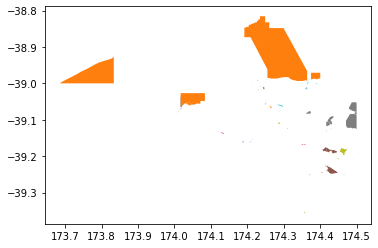

In [22]:
ax = res_intersection.plot(cmap='tab10')

In [23]:
inntersection_geo_data = GeoData(
    geo_dataframe=res_intersection,
    style={'color': 'blue', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    name='Overlapping Area'
)

m = Map(center=(-41.2865, 174.7762), zoom=7, layout=dict(height='800px'))
m.add_layer(inntersection_geo_data)

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [24]:
(res_intersection['geometry'].area.sum() / taranaki_rural_df['geometry'].area.sum()) * 100

1.5465044863223831